Importing the packages I plan on using, reading in the data and taking a quick look at what we're working with.

In [294]:
import pandas as pd                       
import numpy as np                        
import matplotlib.pyplot as plt
from datetime import datetime         

In [463]:
df = pd.read_csv("transactions.csv") 

In [464]:
df.info()
df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1578 entries, 0 to 1577
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   amount            1578 non-null   int64 
 1   account_id        1578 non-null   object
 2   memo              1578 non-null   object
 3   transaction_date  1578 non-null   object
 4   processed_Memo    1577 non-null   object
 5   name              1578 non-null   object
dtypes: int64(1), object(5)
memory usage: 74.1+ KB


,amount,account_id,memo,transaction_date,processed_Memo,name
1573,165000,veLzM9wv48T4N5kZrZNPc9jvrAZY8acmo8YKJ,WWW TRF DDA - 9691,2018-05-04 00:00:00,www trf dda,savings
1574,-30000,qeJzM5Q3A8TNgwje8eg7tz1ogLXPbEtJekx9x,INTERAC E-TRF- 6036,2018-05-03 00:00:00,interac e trf,checking
1575,-120000,qeJzM5Q3A8TNgwje8eg7tz1ogLXPbEtJekx9x,INTERAC E-TRF- 9223,2018-05-03 00:00:00,interac e trf,checking
1576,1370,qeJzM5Q3A8TNgwje8eg7tz1ogLXPbEtJekx9x,C-IDP PURCHASE-9989 -SHELL C02573,2018-05-03 00:00:00,c idp purchase shell c,checking
1577,-100000,qeJzM5Q3A8TNgwje8eg7tz1ogLXPbEtJekx9x,INTERAC E-TRF- 4919,2018-05-03 00:00:00,interac e trf,checking


Before getting started I just want to plot the income amounts to see what they look like over time.

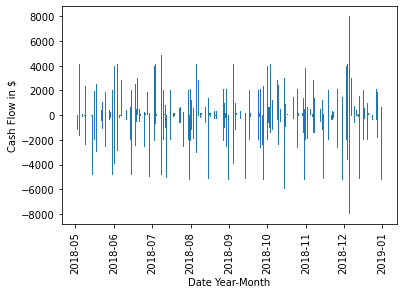

In [469]:
plt.bar(df.transaction_date, df.amount*1/100) # dividing by 100 to get $ amount
plt.xlabel('Date Year-Month')
plt.ylabel('Cash Flow in $')
plt.xticks(rotation=90);

Right off the start it does look like there are some consisistent negative (income) spikes occuring bi-weekly. Let's take a closer look at the income sources by first filter out any positive amount values in the account and then using value counts.

In [449]:
df_neg = df.loc[(df['amount'] < 0),['amount', 'memo','transaction_date']]
pd.value_counts(df_neg.memo)

PAYMENT - THANK YOU / PAIEMENT - MERCI    53
DEPOSIT INTEREST                          30
PAYROLL DEPOSIT -IDS MANAGEMENT           16
INSURANCE -RBC INSURANCE:                  5
TF 3367#3978-557                           2
                                          ..
WWW TRANSFER - 1013                        1
WWW TRANSFER - 5545                        1
INTERAC E-TRF- 2871                        1
WWW TRANSFER - 8347                        1
WWW TRANSFER - 7084                        1
Name: memo, Length: 441, dtype: int64

The first thing that has to be removed are credit card payments, WWW also indicates a trasnfer between two personal account so those can be removed as well. RBC insurance does not sound like an income either, so those transactions will not be considered income. Let's remove these rows and add another date column which does not include the date. This will allow us to group incomes by month and year which will aid in the calculation of monthly income.

In [420]:
df = df[df.name != "credit card"]

In [421]:
df['transaction_date'] = pd.to_datetime(df['transaction_date']) 
df['year_month'] = df['transaction_date'].dt.strftime('%Y-%m') 
df['day'] = df['transaction_date'].dt.strftime('%d')
df = df[~df['memo'].str.contains("WWW ")] 
df = df[~df['memo'].str.contains("RBC")]

Lets created a new data frame that consists of only the incomes by filtering out the expenses and includes our income amount, memo, and a variety of dates.

In [422]:
income = df.loc[(df['amount'] < 0),['amount', 'memo','transaction_date','year_month','day']] # filter out expenses

Now that the expenses have been roemoved, we can look into the income sources. The first thing I'd look to do is sort the transactions by their day of the month so that we can see which days the majority of the income flows into their accounts which will give us a good idea of the pay cycle.

In [423]:
daily_sorted = income.sort_values('day')

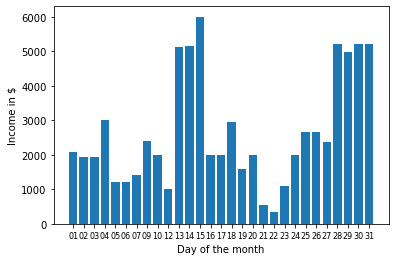

In [424]:
plt.bar(daily_sorted.day, daily_sorted.amount*-1/100) # switching the sign and getting $ amount
plt.xlabel('Day of the month')
plt.ylabel('Income in $')
plt.xticks(fontsize=8);

By looking at the peaks and troughs of the bar plot, we can see that most income flows into the account at the middle of the month and at the end of the month. This suggests that there is a bi-weekly pay schedule. Lets take a look at memos labeled PAYROLL only, as these incomes should be consistent considering they are likely coming from an employer.

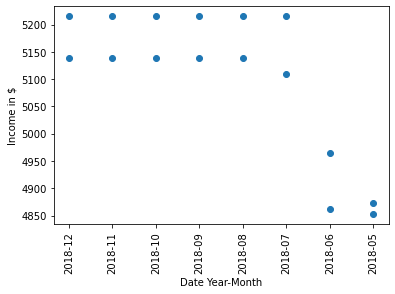

In [425]:
payroll_income = df.loc[(df['memo'].str.contains('PAYROLL')),['amount','memo','transaction_date','year_month','day']]
plt.scatter(payroll_income.year_month, payroll_income.amount*-1/100)
plt.xlabel('Date Year-Month')
plt.ylabel('Income in $')
plt.xticks(rotation=90);

The scatter plot above clearly indicates that at least their payroll deposites are on a bi-weekly pay cycle. Perhaps mony flowing into their acount beneath some threshhold amount should be filtered out and not considered as income. This would clearly define the peaks and troughs of the bar plot and provide further evidence of the pay cycle. For now, lets consider everything in the barplot above to be income and from here we'll look at their total monthly income, although there may be some false incomes include in the transactions.

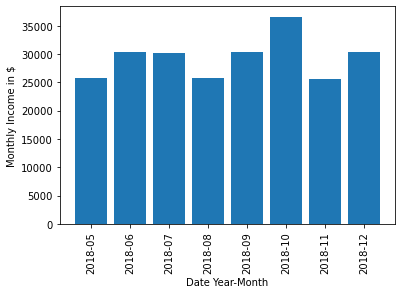

In [426]:
monthly_income = income.groupby('year_month')['amount'].sum().reset_index(name = 'month_total') # group by months
plt.bar(monthly_income.year_month, monthly_income.month_total*-1/100)
plt.xlabel('Date Year-Month')
plt.ylabel('Monthly Income in $')
plt.xticks(rotation=90);

Now we can see the total income per month. But lets try to filter the income a little more by looking at the unique value counts of the memo column. For this, I'm going to apply `pd.value_counts` to the memo column within the income data frame.

In [427]:
pd.value_counts(income.memo)

DEPOSIT INTEREST                                 30
PAYROLL DEPOSIT -IDS MANAGEMENT                  16
TF 3367#3978-557                                  2
TF 0000000022180695424                            2
INTERAC E-TRF- 4911                               1
                                                 ..
WWW3RD PTY DEP-0569                               1
INTERAC E-TRF- 4919                               1
INTERAC E-TRF- 2602                               1
WWW3RD PTY DEP-0490                               1
INTERAC E-TRANSFER RECEIVED 2018174141652E98B     1
Name: memo, Length: 203, dtype: int64

Ok, that didn't work great. It looks like there are a lot of unique IDs at the end of Interac and 3rd party transation deposits. Lets remove the remainder of the string following "INTERAC" and following "WWW3RD".

In [429]:
income.loc[income['memo'].str.contains('INTERAC '), 'memo'] = 'INTERAC'
income.loc[income['memo'].str.contains('WWW3RD '), 'memo'] = 'WWW3RD'
pd.value_counts(income.memo)

INTERAC                                                    96
WWW3RD                                                     76
DEPOSIT INTEREST                                           30
PAYROLL DEPOSIT -IDS MANAGEMENT                            16
TF 0000000022180695424                                      2
TF 3367#3978-557                                            2
MOBILE DEP- 0665                                            1
MOBILE DEP- 8322                                            1
MOBILE DEP- 5130                                            1
MOBILE DEP- 5378                                            1
MOBILE DEP- 5296                                            1
MOBILE DEP- 1154                                            1
INT E-TRF CAN- 7481                                         1
PTB DEP -- TX606941                                         1
MOBILE DEP- 8885                                            1
MISC PAYMENT - TRANSFERWISE                                 1
INT E-TR

That's better. I believe it's safe to say that everything with one inflow to the account throughout the 8 months of data would not be considered income. Let's remove those rows.

In [430]:
sub_df = income[income.groupby('memo').memo.transform('count')>1].copy() 
pd.value_counts(sub_df.memo)

INTERAC                            96
WWW3RD                             76
DEPOSIT INTEREST                   30
PAYROLL DEPOSIT -IDS MANAGEMENT    16
TF 3367#3978-557                    2
TF 0000000022180695424              2
Name: memo, dtype: int64

Ok, that looks cleaner now. They receive a total of 96 e-transfers over the span of 8 months, so perhaps they collect rent from 12 tenants which are supposed to follow a strict pay cycle, but that cycle may vary. They also receive several inflows of money from a 3rd party of some sort along with their payroll. Finally, deposit interest, and the 4 TF transactions may have to be removed as they're looking a little suspicious as far as income goes. Let's see what the pay cycle box plot looks like and go from there.

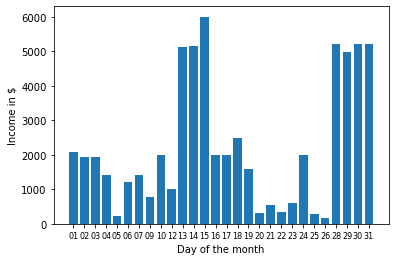

In [431]:
daily_reduced = sub_df.sort_values('day')
plt.bar(daily_reduced.day, daily_reduced.amount*-1/100)
plt.xlabel('Day of the month')
plt.ylabel('Income in $')
plt.xticks(fontsize=8);

Getting better for sure. Clear peaks in the bar plot at mid-month and end-month which further suggests a bi-weekly pay cycle. Let's remove the final odds and ends, then create another bar plot and finally looks at the monthly income.

In [432]:
sub_df = income[income.groupby('memo').memo.transform('count')>2].copy() 

In [433]:
sub_df = sub_df[~sub_df['memo'].str.contains("INTEREST")]
pd.value_counts(sub_df.memo)

INTERAC                            96
WWW3RD                             76
PAYROLL DEPOSIT -IDS MANAGEMENT    16
Name: memo, dtype: int64

Let's look at the pay cycle bar plot now that we have narrowed it down to 3 income sources.

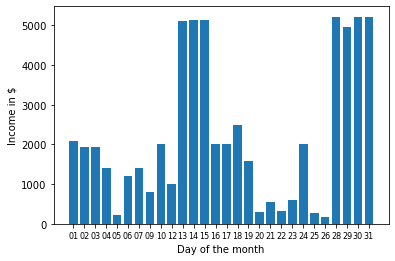

In [434]:
daily_reduced = sub_df.sort_values('day')
plt.bar(daily_reduced.day, daily_reduced.amount*-1/100)
plt.xlabel('Day of the month')
plt.ylabel('Income in $')
plt.xticks(fontsize=8);

The peaks at mid-month and end-month are much more clearly defined. There also seems to be a substantial amount of income in the first few days of each month, this could be rental income. Lets look at the value counts of days on the "INTERAC" labels. This should provide us with a better understanding of the popular days which they receive e-transfers and perhaps suggest a pay cycle.

In [435]:
interac_income = income.loc[(df['memo'].str.contains('INTERAC')),['amount','memo','transaction_date','year_month','day']]
pd.value_counts(interac_income.day)

03    16
04     9
01     7
16     6
25     6
29     5
18     5
09     4
13     4
06     4
10     3
07     3
14     3
17     3
31     3
30     2
21     2
19     2
24     2
15     2
23     1
02     1
12     1
05     1
28     1
Name: day, dtype: int64

The first fews day of the month are popular, maybe they collect rent at the begining of the month and all of the rows that contain an e-transfer after the 5th day should be removed and not considered as income. For now I'm going to look at the monthly income for what we've filtered it down to at this point.

In [436]:
reduce_month = sub_df.groupby('year_month')['amount'].sum().reset_index(name = 'month_total')

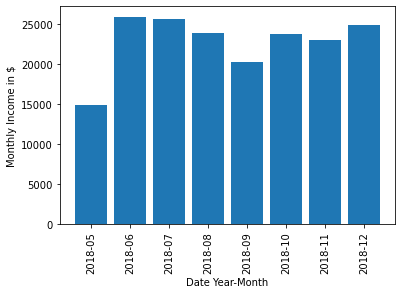

In [439]:
plt.bar(reduce_month.year_month, reduce_month.month_total*-1/100)
plt.xlabel('Date Year-Month')
plt.ylabel('Monthly Income in $')
plt.xticks(rotation=90);

So their monthly income has definetly decreased after removing a lot of the "junk", although I think there is still more that could be removed.

I planned on using the fuzzywuzzy package to replace similar strings mor efficiently which would allow me to distiguish the number of unique income sources much faster and categroize them, then look for pay cycles within each category. If an income in this sorted transaction dataframe looked like a one time income (non-repeating), or looked like a small amount (perhaps an e-transfer from a friend), then I would not include said observation. This would not only produce a more accurate total monthly income, but it would also outline the pay cycle more clearly as the bar plot that I created above is not quite obvious other than some large incomes at the begining which I believe could be rental income and then there are the mid-month and end-month incomes. Had I not been commited to my current job throughout the day, I would've like to implement this.

If you've made this far, I appreciate the opportunity and I hope that you like that work that I've done!